In [20]:
import random
from math import dist
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import math
np.random.seed(1)
simulation_time = 3*60*60
area_width = 500.
area_height = 500.
cluster_num = 5
cluster_R = 1.
node_num = 1
alpha = 1.75
alpha_min = 1.
alpha_max = 500
beta = 1.8
beta_min = 1
beta_max = 60*60*3
side_for_clus = min(area_width, area_height)
TPL = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
def generate_angle():
    return np.random.uniform(0,360)
def power_law(k,a,m):
    return k*(m**a)
def prob_explore( node_visited_num):
    return 0.6 * (node_visited_num ** -0.21 )
def set_pos_of_clus(n = cluster_num , r = cluster_R, side = side_for_clus):
    output = []
    i = 0
    while i < n:
        qualified = True
        x = np.random.uniform(0+r,side-r)
        y = np.random.uniform(0+r,side-r)
        point = [x,y]
        for node in output:
            if dist(point,node) < r:
                qualified = False
        if qualified:
            i += 1
            output.append(point)
    return np.array(output)
def set_clus_prob(n = cluster_num):
    output = np.random.dirichlet(np.ones(n),size=1)
    return output

class Cluster():
    def __init__(self):
        self.data = set_pos_of_clus()
        self.prob = set_clus_prob()
        self.r = [cluster_R for _ in range(cluster_num)]
    def getr(self):
        return self.r
    def getdata(self):
        return self.data
    def getclus_prob(self):
        return self.prob
def assign_cluster( prob_list, nn = node_num, cn = cluster_num):
    return(np.random.choice( cn, nn, replace=True, p=prob_list[0]) )
    
def set_node_data(clusdata, clusprob, nn = node_num, r = cluster_R ): #data[node_index] = [x,y] 
    clus_index = assign_cluster(clusprob)
    output = []
    validrange = r/2
    for i in range(nn):
        cx,cy = clusdata[ clus_index[i] ]
        x = np.random.uniform(-validrange,validrange) + cx
        y = np.random.uniform(-validrange,validrange) + cy
        output.append([x,y])
    return (np.array(output),clus_index)
def set_init_status(nn = node_num):   #status[node_index] = 0(ready) or 1(moving) or 2(pausing)
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_movingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_pausingtime(nn = node_num):
    output = []
    for i in range(nn):
        output.append(0)
    return np.array(output)
def set_init_velocity(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0,0])
    return np.array(output)
def set_init_des(nn = node_num):
    output = []
    for i in range(nn):
        output.append([0,0])
    return np.array(output)
#def set_init_cluster( clus_index ):
#    nn = len(clus_index)
#    init_cluster = []
#    for i in range(nn):
#        init_cluster.append( {clus_index[i] : 1})
#    return init_cluster
def set_init_visited(data): # visited[node_index][0] = node_index's [x,y,total_visited_times]
    visited = []
    nn = len(data)
    for i in range(nn):
        x, y = data[i]
        visited_data= [x,y,1]
        visited.append( [visited_data] )
    return visited
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) )
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def revisit(visited,node_index):
    total_visited = 0
    prob = []
    total_locations = len(visited[node_index])
    for i in range( total_locations):
        total_visited += visited[node_index][i][2]
    for j in range( total_locations ):
        prob.append( visited[node_index][j][2] / total_visited )
    revisited_index = np.random.choice( [i for i in range(total_locations)], 1, replace=True,p=prob )
    revisited_index = revisited_index[0] # change[ int ] to int because np.random.choice return [int]
    visited[node_index][revisited_index][2] += 1
    x,y,_ = visited[node_index][revisited_index]
    return np.array([x,y])
def explore(data,node_index):
    angle =generate_angle()
    flight = TPL(alpha,alpha_min,alpha_max,np.arange(1))
    flight = flight[0]
    #print(f" during explore flight = {flight} ")
    co = math.cos(angle)
    si = math.sin(angle)
    #print(f" angle = {angle}, sin ={ si} , cos = {co}")
    #print(f" data[0][0] = {data[node_index][0]} , data[0][1] = {data[node_index][1]}")
    x2 = data[node_index][0] + (flight * co )
    #print(f"x2 = {data[node_index][0]} + {flight * co}")
    y2 = data[node_index][1] + (flight * si )
    #print(f"y2 = {data[node_index][1]} + {flight * si}")
    #x2 = x2[0] # x2 is a nparray ,change to int
    #y2 = y2[0] # y2 is a nparray ,change to int
    if x2 > area_width :
        x2 = area_width
    if x2 < 0:
        x2 = 0
    if y2 > area_height:
        y2 = area_height
    if y2 < 0:
        y2 = 0
    #print(f"x2 = {x2} , y2 = {y2}")
    return np.array([x2,y2])
def next_destination(data, visited, node_index):
    result = explore_or_revisit(visited, node_index)
    #print(f"result = {result}")
    if result :
        x,y = explore(data, node_index)
        #print(f" x= {x} , y = {y}")
        visited_before = False
        #print(f"visited_before = {visited_before}")
        #print(f" len of visited[0] = {len(visited[node_index])}")
        for i in range( len(visited[node_index]) ):
            x1, y1, _ = visited[node_index][i]
            #print(f"x1 = {x1},y1 = {y1}")
            if x1 == x and y1 == y :
                visited[node_index][i][2] += 1
                visited_before = True
            break
        if visited_before == False:
            value = [x,y,1]
            visited[node_index].append(value)
        return np.array([x,y])
    else:
        x,y = revisit(visited, node_index)
        return np.array([x,y])
def get_pausingtime():
    pause_time = TPL(beta,beta_min,beta_max,np.arange(1))
    return pause_time[0]  # pause_time = [int]
def compute_velocity_and_time(data, destination, node_index):
    flight = math.dist(data[node_index], destination)
    x2, y2 = destination
    x1, y1 = data[node_index]
    if flight == 0 :
        return (np.array([0,0]), 0 )
    if flight >= 500:
        time = (1.37 * flight ** (1-0.36))
        speed = ( flight / (1.37 * flight ** (1-0.36)))
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
    else:
        time = (18.72 * flight ** (1-0.79))
        speed = ( flight / (18.72 * flight ** (1-0.79)) )
        velocity = np.array( [speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        return velocity, time
class Node():
    def __init__(self, clusdata, clusprob):
        self.data, clus_index = set_node_data(clusdata, clusprob)
        self.visited = set_init_visited(self.data)
        self.status = set_init_status()
        self.des = set_init_des()
        self.velocity = set_init_velocity()
        self.movingtime = set_init_movingtime()
        self.pausingtime = set_init_pausingtime()
       # self.cluster_list = set_init_cluster(clus_index)
    def get_data(self):
        return self.data
    def get_visited(self):
        return self.visited
    def get_status(self):
        return self.status
    def get_des(self):
        return self.des
    def get_velocity(self):
        return self.velocity
    def get_movingtime(self):
        return self.movingtime
    def get_pausingtime(self):
        return self.pausingtime
    def set_status(self, value, node_index):
        self.status[node_index] = value
    def set_velocity(self, value, node_index):
        self.velocity[node_index] = value
    def set_des(self, value, node_index):
        self.des[node_index] = value
    def set_movingtime(self, value, node_index):
        self.movingtime[node_index] = value
    def set_pausingtime(self, value , node_index):
        self.pausingtime[node_index] = value
    def set_data(self, value , node_index):
        x, y = value
        self.data[node_index][0] += x
        self.data[node_index][1] += y
cluster = Cluster()
print(f"cluster = {cluster.getdata()}")
node = Node(cluster.getdata(), cluster.getclus_prob())
print(f"node.data = {node.get_data()}")
print(f"node.visited = {node.get_visited()}")
print(f"node.status = {node.get_status()}")
print(f"visited = {node.get_visited()}")
print(f"velocity = {node.get_velocity()}")
print(f"pausingtime = {node.get_pausingtime()}")
print(f"status = {node.get_status()}")
print( "#########simulation Start######") 
time = 0
while (time < simulation_time):
    for i in range(node_num):
        print(f" time = {time}, node[0] = {node.get_data()[i]},des ={node.get_des()[i]},vi = {node.get_visited()[i]}")
        if (node.get_status())[i] == 0:
            des = next_destination(node.get_data(), node.get_visited(), i)
            #print(f"des = {des}")
            if des[0] != node.get_data()[i][0] or des[1] != node.get_data()[i][1]:
                node.set_des(des,i)
                node.set_status(1,i)
                velocity, movingtime = compute_velocity_and_time(node.get_data(), des, i)
                movingtime = int(movingtime) #無條件進位+1後，更新位置所以後來要在-1等於沒+
                node.set_data(velocity, i) #update data
                if movingtime != 0:
                    node.set_velocity(velocity, i)
                    node.set_movingtime(movingtime,i)
                else:
                    node.set_des([0,0],i)
                    pausingtime = get_pausingtime()
                    pausingtime = int(pausingtime)
                    if pausingtime != 0:
                        node.set_status(2,i)
                        node.set_pausingtime(pause_time,i)
                    else:
                        node.set_status(0,i)
            else:
                pausingtime = get_pausingtime()
                print(f"pausingtime = {pausingtime}")
                pausingtime = int(pausingtime)
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
        elif (node.get_status())[i] == 1:
            if node.get_movingtime()[i] == 1:
                node.set_data( -node.get_data()[i],i)
                node.set_data(node.get_des()[i],i)
                node.set_velocity( np.array([0,0]),i)
                node.set_movingtime(0,i)
                node.set_des( np.array([0,0]), i)
                pausingtime = get_pausingtime()
                pausingtime = int(pausingtime)
                print(f"pausingtime = {pausingtime}")
                if pausingtime != 0:
                    node.set_status(2,i)
                    node.set_pausingtime(pausingtime,i)
                else:
                    node.set_status(0,i)
            else:
                node.set_data(velocity, i) #update data
                node.set_movingtime( node.get_movingtime()[i]-1, i)
        else:
            if node.get_pausingtime()[i] == 1:
                node.set_pausingtime(0,i)
                node.set_status(0,i)
            else:
                node.set_pausingtime( node.get_pausingtime()[i] -1 , i)
    time += 1
print(f" time = {time}, node[0] = {node.get_data()[i]} ")
print(f" node.visited[0] = {node.get_visited()[0]}")
#cluster_list = set_pos_of_clus()
#print(type(cluster_list))
#print(cluster_list)
#x = []
#y = []
#for i in range( cluster_num):
#    x0 , y0= zip(cluster_list[i])
#    x.append(x0)
#    y.append(y0)
    
#plt.plot(x,y,'ro')
#plt.show()

        

cluster = [[208.67695834 359.72159773]
 [  1.05695866 151.56162117]
 [ 74.08443363  46.98462019]
 [ 93.75758527 173.08924207]
 [198.59020217 269.33073353]]
node.data = [[ 93.67489007 173.1479319 ]]
node.visited = [[[93.67489006844724, 173.14793189588352, 1]]]
node.status = [0]
visited = [[[93.67489006844724, 173.14793189588352, 1]]]
velocity = [[0 0]]
pausingtime = [0]
status = [0]
#########simulation Start######
 time = 0, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 1]]
pausingtime = 9976.020375272248
 time = 1, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 

 time = 665, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 666, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 667, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 668, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 669, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 670, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 671, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 672, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 673, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147931895883

 time = 1420, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1421, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1422, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1423, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1424, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1425, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1426, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1427, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 1428, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 2311, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2312, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2313, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2314, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2315, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2316, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2317, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2318, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 2319, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 3252, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3253, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3254, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3255, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3256, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3257, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3258, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3259, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 3260, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 4162, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4163, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4164, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4165, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4166, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4167, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4168, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4169, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 4170, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 5099, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5100, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5101, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5102, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5103, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5104, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5105, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5106, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5107, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 5946, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5947, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5948, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5949, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5950, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5951, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5952, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5953, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 5954, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 6922, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6923, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6924, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6925, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6926, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6927, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6928, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6929, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 6930, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 7880, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7881, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7882, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7883, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7884, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7885, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7886, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7887, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 7888, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 8764, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8765, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8766, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8767, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8768, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8769, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8770, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8771, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 8772, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 9512, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9513, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9514, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9515, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9516, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9517, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9518, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9519, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2]]
 time = 9520, node[0] = [ 93.67489007 173.1479319 ],des =[0 0],vi = [[93.67489006844724, 173.147

 time = 10530, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10531, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10532, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10533, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10534, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10535, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10536, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2], [500.0, 58.73873710259849, 1]]
 time = 10537, node[0] = [500.  58.],des =[0 0],vi = [[93.67489006844724, 173.14793189588352, 2],

[15.88167966]
##########
cx = 186.95675160512326, cy = 97.53618821973457
x = 187.03778726254134, y = 97.23691570776965 
cx = 50.521400331963434, cy = 58.28743600102263
x = 50.55094694244183, y = 58.6818684194502 
cx = 50.521400331963434, cy = 58.28743600102263
x = 50.32639430779865, y = 58.65838161018368 
cx = 44.91049325860617, cy = 118.06866306971283
x = 45.319238531464556, y = 117.89850763239471 
cx = 44.91049325860617, cy = 118.06866306971283
x = 45.09356762494273, y = 118.4678840192788 
cx = 186.95675160512326, cy = 97.53618821973457
x = 186.53244848688155, y = 97.91477608293934 
cx = 44.91049325860617, cy = 118.06866306971283
x = 44.60133262187465, y = 118.41843197973076 
cx = 186.95675160512326, cy = 97.53618821973457
x = 187.12387039382247, y = 97.38052741518462 
cx = 44.91049325860617, cy = 118.06866306971283
x = 44.56186882859897, y = 118.20403403120127 
cx = 409.7317563142233, cy = 299.618732195011
x = 410.079544357938, y = 299.94058156977496 


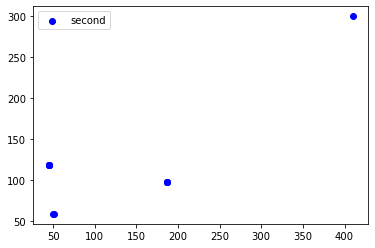

[1 0 0 4 4 1 4 1 4 2]
[{1: 1}, {0: 1}, {0: 1}, {4: 1}, {4: 1}, {1: 1}, {4: 1}, {1: 1}, {4: 1}, {2: 1}]
[[187.03778726  97.23691571]
 [ 50.55094694  58.68186842]
 [ 50.32639431  58.65838161]
 [ 45.31923853 117.89850763]
 [ 45.09356762 118.46788402]
 [186.53244849  97.91477608]
 [ 44.60133262 118.41843198]
 [187.12387039  97.38052742]
 [ 44.56186883 118.20403403]
 [410.07954436 299.94058157]]
 visited[0] = [[187.03778726254134, 97.23691570776965, 1]]
revisited_index = [0]
revisited_index[0] = 0
rx = 187.03778726254134, ry = 97.23691570776965 
r = True
prob_explore or 0= 0.22763747615669036 
[0.58992313 0.19783278]
angle() = 154.55906014193724
sin = 0.9618138700055118, cos = 0.5050484537384373
 nl = [[187.03778726  97.23691571]
 [ 50.55094694  58.68186842]
 [ 50.32639431  58.65838161]
 [ 45.31923853 117.89850763]
 [ 45.09356762 118.46788402]
 [186.53244849  97.91477608]
 [ 44.60133262 118.41843198]
 [187.12387039  97.38052742]
 [ 44.56186883 118.20403403]
 [410.07954436 299.94058157]] 
 x

In [41]:
P = lambda ALPHA, MIN, MAX, SAMPLES: ((MAX ** (ALPHA+1.) -1.) * rand(*SAMPLES.shape) +1.) ** (1./(ALPHA+1.))
import math
area_width = 500.
area_height = 500.
print(P(0.5, 10 ,20 , np.array([2])))
def set_clus_popu(n = cluster_num):
    output = np.random.dirichlet(np.ones(n),size=1)
    return output

def assign_cluster( prob_list, nn = node_num, cn = cluster_num):
    return (np.random.choice( cn, nn,replace=True, p = prob_list))
pl = set_clus_prob()
#print(pl)
a = assign_cluster(prob_list = pl[0])
#print(a)

print("##########")
def set_node_data(clusdata, clusprob,nn = node_num, r = cluster_R):
    clus_index = assign_cluster(clusprob[0])
    output = []
    validrange = r/2
    for i in range(nn):
        cx,cy = clusdata[ clus_index[i] ]
        print(f"cx = {cx}, cy = {cy}")
        x = np.random.uniform(-validrange,validrange) + cx
        y = np.random.uniform(-validrange,validrange) + cy
        print(f"x = {x}, y = {y} ")
        output.append([x,y])
    return (np.array(output),clus_index)
clusdata = set_pos_of_clus()
nl,cluster_list= set_node_data(clusdata=clusdata, clusprob=pl)
nx = []
ny = []
for i in range( node_num):
    x0 , y0= zip(nl[i])
    nx.append(x0)
    ny.append(y0)
x = []
y = []
for i in range( cluster_num):
    x0 , y0= zip(clusdata[i])
    x.append(x0)
    y.append(y0)
#print(f"x={x}, y={y}" )
#print(f"nx={nx}, ny = {ny}")
fig = plt.figure()
ax1 = fig.add_subplot(111)
#ax1.scatter(x,y,c='r',marker='s', label='first')
ax1.scatter(nx,ny,c='b',marker='o', label='second')
plt.legend(loc='upper left')
plt.show()

def set_init_cluster( clus_index ):
    nn = len(clus_index)
    init_cluster = []
    for i in range(nn):
        init_cluster.append( {clus_index[i] : 1})
    return init_cluster
dic = set_init_cluster(cluster_list)
print( cluster_list )
print(dic)
print(nl)
def set_init_visited(data): # visited[node_index][0] = node_index's [x,y,total_visited_times]
    visited = []
    nn = len(data)
    for i in range(nn):
        x, y = data[i]
        visited_data= [x,y,1]
        visited.append( [visited_data] )
    return visited
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) )
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def explore_or_revisit(visited, node_index):
    prob_ex = prob_explore( len(visited[node_index]) )
    prob_re = 1 - prob_ex
    prob = [prob_re, prob_ex]
    output = [0,1]
    result = np.random.choice( output, 1, replace=True, p=prob)
    if result == 1:
        return True
    else:
        return False
def revisit(visited,node_index):
    total_visited = 0
    prob = []
    total_locations = len(visited[node_index])
    for i in range( total_locations):
        total_visited += visited[node_index][i][2]
    for j in range( total_locations ):
        prob.append( visited[node_index][j][2] / total_visited )
    revisited_index = np.random.choice( [i for i in range(total_locations)], 1, replace=True,p=prob )
    print(f"revisited_index = {revisited_index}")
    print(f"revisited_index[0] = {revisited_index[0]}")
    x,y,_ = visited[node_index][revisited_index[0]]
    return np.array([x,y])

visited = set_init_visited(nl)
print(f" visited[0] = {visited[0]}")
r = explore_or_revisit(visited,0)
rx,ry = revisit(visited,0)
print(f"rx = {rx}, ry = {ry} ")
print(f"r = {r}")
print(f"prob_explore or 0= {prob_explore(len(visited[0]) + 100)} ")
vv = np.array([1,1090])
print(rand(*vv.shape))
def generate_angle():
    return np.random.uniform(0,360)
print(f"angle() = {generate_angle()}")
print(f"sin = {math.sin(generate_angle())}, cos = {math.cos(generate_angle())}")
alpha = 1.75
alpha_min = 1.
alpha_max = 500
def explore(data,node_index):
    angle =generate_angle()
    flight = TPL(alpha,alpha_min,alpha_max,np.arange(1))
    x2 = data[node_index][0] + (flight * math.cos(angle) )
    y2 = data[node_index][1] + (flight * math.sin(angle) )
    x2 = x2[0]
    y2 = y2[0]
    print(f" x2 = {x2} , y2 = {y2} " )
    if x2 > area_width :
        x2 = area_width
    if x2 < 0 :
        x2 = 0
    if y2 < 0:
        y2 = 0
    if y2 > area_height:
        y2 = area_height
    return np.array([x2,y2])
print(f" nl = {nl} " )
x0,y0 = explore(nl,0)
print(f"x0 = {x0}, y0 = {y0} ")
def set_init_status(nn = node_num):   #status[node_index] = 0(ready) or 1(moving) or 2(pausing)
    output = []
    for i in range(node_num):
        output.append(0)
    return np.array(output)
print(set_init_status(100))
def get_pause_time():
    pause_time = TPL(beta,beta_min,beta_max,np.arange(1)) 
    return pause_time[0]
print(get_pause_time())
def next_destination(data, visited, node_index):
    result = explore_or_revisit(visited, node_index) 
    if result :
        x,y = explore(data, node_index)
        for i in range( len(visited[node_index]) ):
            x1, y1, _= visited[node_index][i]
            if x1 == x and y1 == y :
                visited[node_index][i][2] += 1
            break
        return np.array([x,y])
    else:
        x,y = revisit(visited, node_index)
        return np.array([x,y])
dest = next_destination(nl, visited, 0)
print(f"dest = {dest}")
def compute_velocity(data, destination, node_index):
    flight = math.dist(data[node_index], destination)
    x2, y2 = destination
    x1, y1 = data[node_index]
    if flight == 0 :
        return np.array([0,0]),0
    if flight >= 500:
        time = (1.37 * (flight ** (1-0.36)) )
        speed = ( flight / (1.37 * (flight ** (1-0.36))  ))
        velocity = np.array([speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ]) 
        print(f"speed = {speed}, flight ={flight}, x2 ={x2} ,x1 ={x1}, y2 = {y2}, y1 = {y1} ")
        return velocity, time
    else:
        time = (18.72 * (flight ** (1-0.79)) )
        speed = ( flight / (18.72 * (flight ** (1-0.79)) ) )
        velocity = np.array([speed * ( x2 - x1 )/flight, speed * (y2 - y1)/flight ] )
        print(f"speed = {speed}, flight ={flight}, x2 ={x2}, x1= {x1}, y2 = {y2} y1 = {y1} ")
        return velocity , time
velo_list, time = compute_velocity(nl,dest,0)
time = int(time) + 1
print(f"data[0] = {nl[0]} ")
print(f"velo_list = {velo_list}, time = {time}")
print(f"dest = {dest}, node[0] = {nl[0]} ")
count = 0
#while nl[0][0] < dest[0] or nl[0][1] < dest[1] :
#    nl[0][0] += velo_list[0]
#    nl[0][1] += velo_list[1]
#    count += 1
#print(f"count = {count}")
print(f" nl = {nl}, velo_list = {velo_list}")
for i in range(time):
    nl[0][0] += velo_list[0]
    nl[0][1] += velo_list[1]
print(f"node[0] = {nl[0]}")
print(f"visited = {visited}")
print(f"visited[0] = {visited[0]}")
def add_visited( des, visited, node_index):
    x,y = des
    value = np.array([x,y,1])
    a = np.vstack([visited[node_index],value])
    print(f"visited[0] = {visited[node_index]}")
    print(f"a = {a}")
    visited[node_index] = a
add_visited( dest,visited,0)
print(f"visited[0] = {visited[0]}")